# 作业5：二值图的轮廓跟踪和形态学运算
- Author: Wei Jiangnan 2024.9
--------------------------------------------------------------------------------------------------------------------------
#### 1. 实现课件中提到的轮廓跟踪算法
- 算法原型为`findContours(binary, start_x, start_y)`，其中`binary`为二值图，`start_x`和`start_y`为轮廓的起始点。
- 函数的返回值为一个`list`，其中每个元素为一个点，每个点为一个`tuple`，其中包含两个元素，分别为`x`和`y`坐标，例如`[(x1, y1), (x2, y2), ...]`，代表轮廓上的点的坐标。
--------------------------------------------------------------------------------------------------------------------------
#### 2. 实现课件中提到的形态学运算
- 膨胀`dilate(binary, kernel)`。
- 腐蚀`erode(binary, kernel)`。
- 开运算`open(binary, kernel)`。
- 闭运算`close(binary, kernel)`。
- 形态学梯度`gradient(binary, kernel)`。
- 顶帽`tophat(binary, kernel)`。
- 黑帽`blackhat(binary, kernel)`。
- 上述函数中`binary`为二值图，`kernel`为运算的核，核的大小为`kernel.shape`，核的中心为`kernel.shape[0]//2, kernel.shape[1]//2`。
- **`[注意]`** 核需要进行映像后再进行运算。
--------------------------------------------------------------------------------------------------------------------------


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### 1 轮廓跟踪 （35）
- 实现课件中提到的轮廓跟踪算法`findContours(binary, start_x, start_y)`，其中`binary`为二值图，`start_x`和`start_y`为轮廓的起始点。
- 只需考虑图像中只有一个封闭轮廓的情况。
- 对于轮廓的起始点，你可以手动指定，也可以实现算法自动寻找起始点。已经提供了一个自动寻找起始点的算法，你可以直接使用，也可以自己实现。
- 函数的返回值为一个`list`，其中每个元素为一个点，每个点为一个`tuple`，其中包含两个元素，分别为`x`和`y`坐标，例如`[(x1, y1), (x2, y2), ...]`，代表按顺序排列的轮廓上的点的坐标。

#### 1-1 自动寻找起始点
- 你可以直接使用下面的代码，也可以自己实现。
- **`[注意]`** 本作业中的测试图片的背景为白色，前景为黑色，因此寻找起始点的算法是基于这个假设的，如果你自己实现了寻找起始点的算法，也需要基于这个假设。


In [61]:
def get_start(binary):
    '''
    Args:
        binary:二值化图像
    Returns:
        i,j:左上角像素的坐标
    '''
    w,h=binary.shape
    #找到左上角像素
    for i in range(w):
        for j in range(h):
            if not binary[i][j]>0:
                return i,j

#### 1-2 轮廓跟踪算法
- 函数原型为`findContours(binary, start_x, start_y)`，其中`binary`为二值图，`start_x`和`start_y`为轮廓的起始点。

In [62]:

def edge_follow(binary,start_x,start_y):
    '''
    Args:
        binary:二值化图像
        start_x,start_y:边缘起始点x,y坐标
    Returns:    
        edge_list:按顺序排列的边缘点位置列表
    '''
    edge_list = []
    direction = [(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)]
    start_point = (start_x, start_y)
    cur_point = start_point
    cur_direction = 0
    while True:
        edge_list.append(cur_point)
        found_next_point = False

        for i in range(8):
            next_direction = (cur_direction + i) % 8
            next_point = (cur_point[0] + direction[next_direction][0], cur_point[1] + direction[next_direction][1])

            if binary[next_point[0],next_point[1]]==0:
                cur_point = next_point
                cur_direction = (next_direction - 2 + 8) % 8
                found_next_point = True
                break

        if not found_next_point or cur_point == start_point:
            break
    return edge_list


#### 1-3 测试边缘跟踪算法
- 下面的代码会对`edge_test.png`二值化后进行边缘跟踪，无需修改，运行后会显示轮廓跟踪的结果。

In [63]:
def draw_edge(binary,edge_list):
    '''
    Args:
        binary:二值化图像
        edge_list:边缘点列表
    Returns:
        new_img:边缘图片
        edge_order:从深到浅的边缘表示跟踪路径
    '''
    w,h=binary.shape
    new_img=np.zeros((w,h),dtype=np.uint8)
    new_img+=255
    edge_order=new_img.copy()
    l=len(edge_list)
    #用从深到浅的边缘表示跟踪路径
    for i in range(l):
        new_img[edge_list[i][0]][edge_list[i][1]]=0
        edge_order[edge_list[i][0]][edge_list[i][1]]=255-(int)(255*i/l)
    return new_img,edge_order

Text(0.5, 1.0, 'edge order')

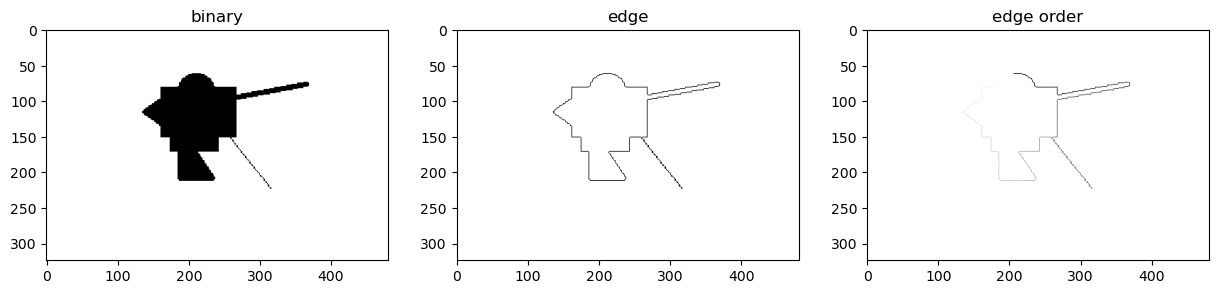

In [64]:
test=cv2.imread("edge_test.png")
gray=cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
ret,binary=cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
start_x,start_y=get_start(binary)
edge_list=edge_follow(binary,start_x,start_y)
new_img,edge_order=draw_edge(binary,edge_list)
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(binary,cmap="gray")
plt.title("binary")
plt.subplot(132)
plt.imshow(new_img,cmap="gray")
plt.title("edge")
plt.subplot(133)
plt.imshow(edge_order,cmap="gray")
plt.title("edge order")


### 2 形态学运算（65）
- 实现课件中提到的形态学运算。

##### 2-1 膨胀（20）
- 膨胀`dilate(binary, kernel)`。

In [38]:
'''
def dilate(binary,kernel):
 
    Args:
        binary:二值化图像
        kernel:结构元素
    Returns:
        new_img:膨胀后的图像

    h_pad, w_pad = kernel.shape[0]//2, kernel.shape[1]//2
    h, w = binary.shape
    new_img = np.zeros_like(binary)
    binary_pad = np.pad(binary, ((h_pad, h_pad), (w_pad, w_pad)), mode='constant', constant_values=0)
    for i in range(h):
        for j in range(w):
            kernel_area = binary_pad[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            # if np.sum(kernel_area * kernel)>0: # 有交集
            #    new_img[i ,j] = 255
            new_img[i, j] = np.max(kernel_area * kernel)
    return new_img
'''
def dilate(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=(0,0))
    dilated_image = np.zeros_like(image)
    for i in range(image_height):
        for j in range(image_width):
            window = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.sum(window * kernel) > 0:
                dilated_image[i, j] = 255
            # dilated_image[i, j] = np.max(window * kernel)
    return dilated_image


#### 2-2 腐蚀（20）
- 腐蚀`erode(binary, kernel)`。

In [39]:
'''

def erode(binary, kernel):

    Args:
        binary:二值化图像
        kernel:结构元素
    Returns:
        new_img:腐蚀后的图像

    h_pad, w_pad = kernel.shape[0]//2, kernel.shape[1]//2
    h, w = binary.shape
    new_img = np.zeros_like(binary)
    binary_pad = np.pad(binary, ((h_pad, h_pad), (w_pad, w_pad)), mode='constant', constant_values=0)
    for i in range(h):
        for j in range(w):
            kernel_area = binary_pad[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            # if np.all(kernel_area & kernel): # 全部包含
            new_img[i, j] = np.min(kernel_area * kernel)
    return new_img

'''
def erode(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=(0,0))
    eroded_image = np.zeros_like(image)
    for i in range(image_height):
        for j in range(image_width):
            window = padded_image[i:i + kernel_height, j:j + kernel_width]
            if np.all(window[kernel == 1] == 255):
                eroded_image[i, j] = 255
    return eroded_image


#### 2-3 开运算（5）
- 开运算`open(binary, kernel)`。

In [40]:
def open(binary,kernel):
    '''
    Args:   
        binary:二值化图像
        kernel:结构元素
    Returns:  
        开运算后的图像
    '''
    eroded = erode(binary, kernel)
    opened = dilate(eroded, kernel)
    return opened

#### 2-4 闭运算（5）
- 闭运算`close(binary, kernel)`。

In [41]:
def close(binary,kernel):
    '''
    Args:   
        binary:二值化图像
        kernel:结构元素
    Returns:
        闭运算后的图像
    '''
    dilated = dilate(binary, kernel)
    closed = erode(dilated, kernel)
    return closed

#### 2-5 形态学梯度（5）
- 形态学梯度`gradient(binary, kernel)`。

In [42]:
def graident(binary,kernel):
    '''
    Args:  
        binary:二值化图像
        kernel:结构元素
    Returns:
        梯度运算后的图像
    '''
    dilated = dilate(binary, kernel)
    eroded = erode(binary, kernel)
    gradient = dilated - eroded
    return gradient

#### 2-6 顶帽（5）
- 顶帽`tophat(binary, kernel)`。

In [43]:
def tophat(binary,kernel):
    '''
    Args:  
        binary:二值化图像
        kernel:结构元素 
    Returns:
       顶帽运算后的图像
    '''
    opened = open(binary, kernel)
    tophat = binary - opened
    return tophat

#### 2-7 黑帽（5）
- 黑帽`blackhat(binary, kernel)`。

In [44]:
def blackhat(binary,kernel):
    '''
    Args:  
        binary:二值化图像
        kernel:结构元素
    Returns:
        黑帽运算后的图像
    '''
    closed = close(binary, kernel)
    blackhat = closed - binary
    return blackhat

#### 2-8 测试形态学运算
- 下面的代码会对`test_img.png`,`test_j.png`,`test_abcd.png`二值化后进行形态学运算，无需修改，运行后会显示形态学运算的结果。

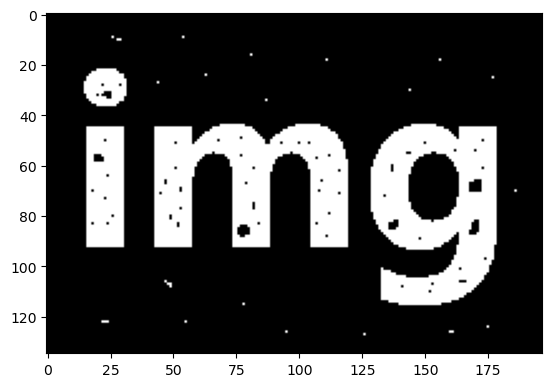

In [45]:
test_img=cv2.imread("test_img.png")
gray=cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
ret,binary=cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
plt.imshow(binary,cmap="gray")

Text(0.5, 1.0, 'blackhat')

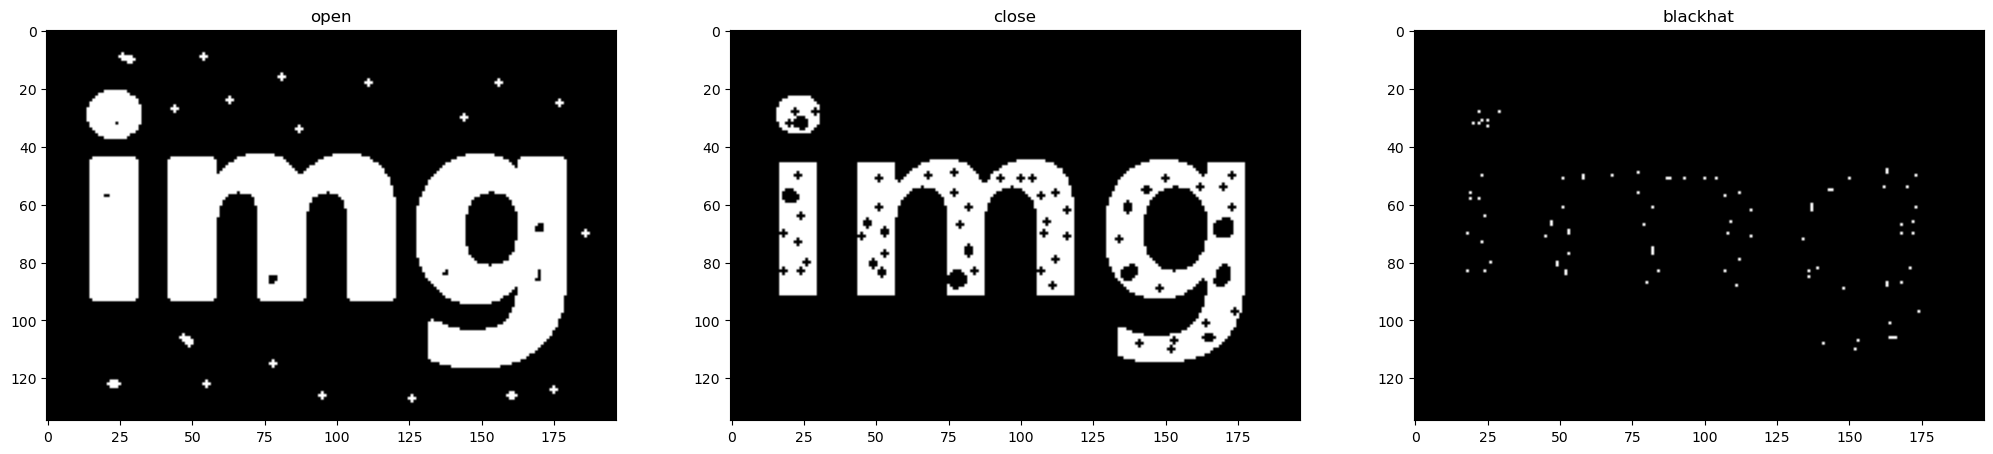

In [46]:
kernel=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.uint8)
open_img=dilate(binary,kernel)
close_img=erode(binary,kernel)
blackhat_img=blackhat(binary,kernel)
plt.figure(figsize=(25, 30))
plt.subplot(131)
plt.imshow(open_img,cmap="gray")
plt.title("open")
plt.subplot(132)
plt.imshow(close_img,cmap="gray")
plt.title("close")
plt.subplot(133)
plt.imshow(blackhat_img,cmap="gray")
plt.title("blackhat")

Text(0.5, 1.0, 'graident')

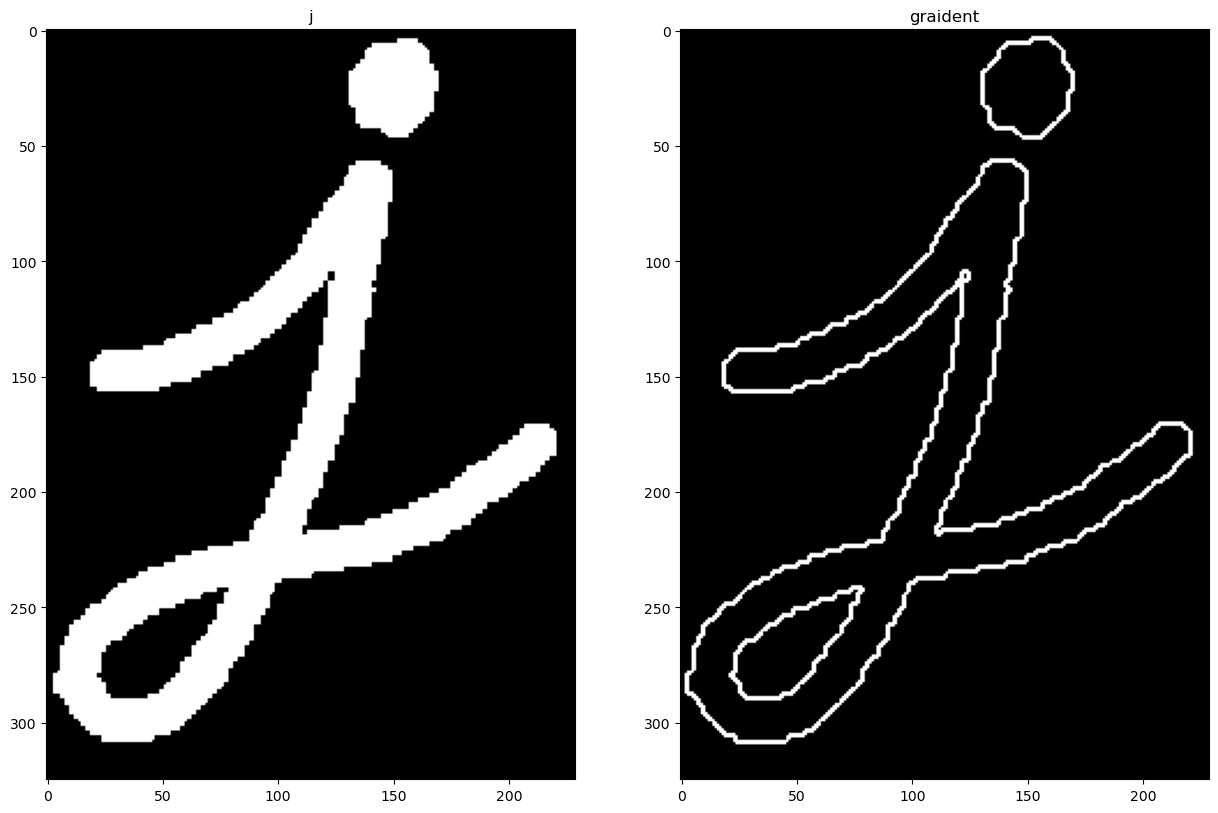

In [47]:
test_j=cv2.imread("test_j.png")
gray=cv2.cvtColor(test_j,cv2.COLOR_BGR2GRAY)
ret,binary=cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
kernel=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.uint8)
graident_img=graident(binary,kernel)
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(binary,cmap="gray")
plt.title("j")
plt.subplot(122)
plt.imshow(graident_img,cmap="gray")
plt.title("graident")

Text(0.5, 1.0, 'tophat')

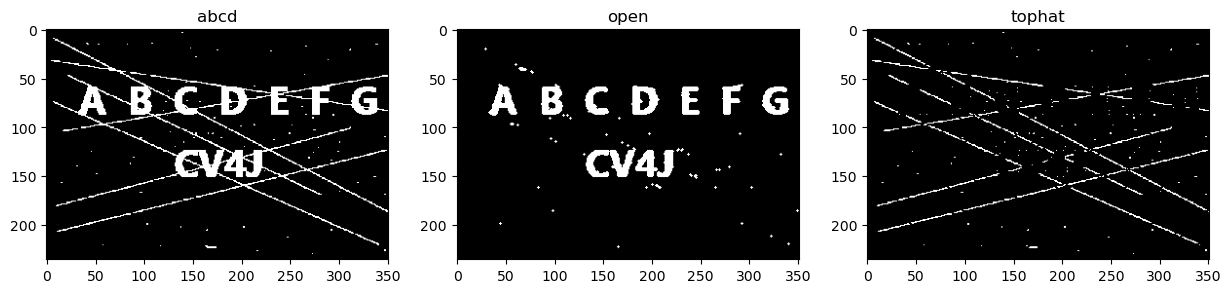

In [48]:
test_abcd=cv2.imread("test_abcd.png")
gray=cv2.cvtColor(test_abcd,cv2.COLOR_BGR2GRAY)
ret,binary=cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
kernel=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype=np.uint8)
open_img=open(binary,kernel)
tophat_img=tophat(binary,kernel)
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(binary,cmap="gray")
plt.title("abcd")
plt.subplot(132)
plt.imshow(open_img,cmap="gray")
plt.title("open")
plt.subplot(133)
plt.imshow(tophat_img,cmap="gray")
plt.title("tophat")

##### 实验收获与感悟
- 请在这里给出你对本次实验的收获与感悟，可以是对本次实验的建议，也可以是对本次实验的心得体会。
    + 学习任务：实现一个边缘跟踪算法；形态学学计算
        + 轮廓提取的方法：也就是跟踪边缘，找到第一个边界点之后不断调整方向，沿着边界走直到形成闭环。
        + 形态学计算
            - 膨胀`dilate(binary, kernel)`。只要存在kernel与图像相交，模板中心像素被填充颜色，使得物体变大，填充小孔以及连接的区域，突出物体边界。
            - 腐蚀`erode(binary, kernel)`。只有图像完全包含kernel时，模板中心像素才填充颜色，使边界减小，去除图像中的毛刺和噪声点。
            - 开运算`open(binary, kernel)`。先腐蚀，再膨胀。去除较小的物体或者噪声，平滑图像。
            - 闭运算`close(binary, kernel)`。先膨胀，再腐蚀。填补物体的小孔，平滑图像。
            - 形态学梯度`gradient(binary, kernel)`。膨胀图像与腐蚀图像的差。可以突出物体边界，提取轮廓。
            - 顶帽`tophat(binary, kernel)`。原始图像与开运算的差。突出亮细节。
            - 黑帽`blackhat(binary, kernel)`。闭运算与原图像的差。突出暗斑。